# Exploration 4. 영화리뷰 감성분석

## 1) 데이터 준비와 확인

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0


/home/aiffel-dj3/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/home/aiffel-dj3/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [4]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [5]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

<UNUSED> the and


In [6]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다.

In [7]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 2) 데이터로더 구성


   - 데이터의 중복 제거
   - NaN 결측치 제거
   - 한국어 토크나이저로 토큰화
   - 불용어(Stopwords) 제거
   - 사전word_to_index 구성
   - 텍스트 스트링을 사전 인덱스 스트링으로 변환
   - X_train, y_train, X_test, y_test, word_to_index 리턴


In [9]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

    X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0


/home/aiffel-dj3/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/home/aiffel-dj3/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [11]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [12]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [13]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

## 3) 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [14]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 4) 모델구성 및 validation set 구성

In [16]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(8, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(8, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           904       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 8)           456       
_________________________________________________________________
global_max_pooling1d (Global (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [17]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


## 5) 모델 훈련 개시

###  모델 학습 시작 !!

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=21  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/21
30/30 [==============================] - 9s 292ms/step - loss: 0.6924 - accuracy: 0.5149 - val_loss: 0.6917 - val_accuracy: 0.5086
Epoch 2/21
30/30 [==============================] - 1s 26ms/step - loss: 0.6860 - accuracy: 0.5490 - val_loss: 0.6821 - val_accuracy: 0.6708
Epoch 3/21
30/30 [==============================] - 1s 26ms/step - loss: 0.6561 - accuracy: 0.6723 - val_loss: 0.6273 - val_accuracy: 0.6999
Epoch 4/21
30/30 [==============================] - 1s 26ms/step - loss: 0.5523 - accuracy: 0.7981 - val_loss: 0.5044 - val_accuracy: 0.8260
Epoch 5/21
30/30 [==============================] - 1s 26ms/step - loss: 0.4058 - accuracy: 0.8796 - val_loss: 0.3956 - val_accuracy: 0.8464
Epoch 6/21
30/30 [==============================] - 1s 26ms/step - loss: 0.2754 - accuracy: 0.9158 - val_loss: 0.3429 - val_accuracy: 0.8548
Epoch 7/21
30/30 [==============================] - 1s 26ms/step - loss: 0.1920 - accuracy: 0.9405 - val_loss: 0.3445 - val_accuracy: 0.8547
Epoch 8/21
3

In [19]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 4s - loss: 0.6967 - accuracy: 0.8298
[0.696743905544281, 0.829800009727478]


 첫번째 시도 : accuracy 84.695.. --> epoch 20 ! 변수를 조작해보자~~!  
 
 두번째 시도 : accuracy 82.28...---> 별다른 변수 수정이 아닌 단순 재시도  
 
 세번째 시도 : accuracy 82. 222..---> epoch 16: 내 생각엔 accuracy가 오버피팅인것 같아서 epoch를 줄여서 시도해 보았다(역시나...)  
 
 네번째 시도 : accuracy 82.4.....----> epoch 30: 오버피팅이 심해지는 것 같아서 다시 시도해봐야겠다..  
 
 다섯번째 시도 : accuracy 82.2799..----> epoch 22: 최적의 변수는 무엇일까....? 처음엔 왜 잘나온거지??  
 
 여섯번째 시도 : accuracy 82.27199..----> epoch 20: 처음에 84나와서 다시 해봤지만 같은 epoch여도 결과가 같지 않을 수 있다는 걸 배운다..  
 
 일곱번째 시도 : accuracy 82.21 ---> epoch 70 : 변수에 차이를 두고 패턴을 알아보자..  
 
 여덟번째 시도 : accuracy 82.19 ---> epoch 21: 학습을 반복할수록 정확도가 떨어지는 건 왜일까???     
 
 아홉번째 시도 : accuracy 84.85..---> epoch 21: 이제보니 변수값을 바꾸면 처음부터 다시 run을 해야 제값이 나오나보다...
 

### 변수가 커지거나 작아진다고 해서 비례하게 결과의 로스값이나 accuracy값이 일정한 패턴이 있는게 아니라는 걸 배운다. 
### 그래서 최적의 값을 찾는게 어려운거고, 사람이 하지 못하는(?) 하기 힘든 것을 AI가 더잘한다는걸 여기서 느끼게 된다..
### 이런 작업을 인간이 하나하나 다 하려면 몇날 몇일을 새거나 파이값을 구하는 것처럼 시대의 난제가 되었을것 같다. 
### 결론은...내가 AI가 있는 세상에 태어나길 잘했다고 느낀다.. !

## 6) Loss, Accuracy 그래프 시각화

In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


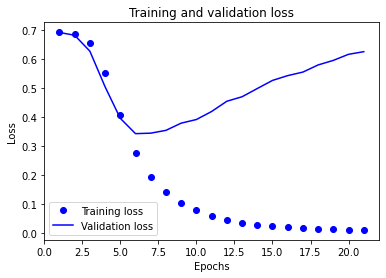

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

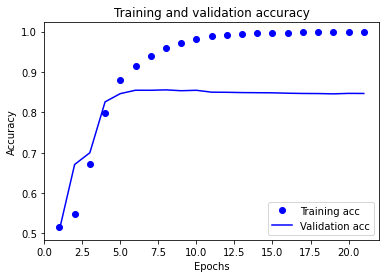

In [22]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

### word2vec에서 너무 오류가 나서 확인차 아래 2개 모델을 다시 사용해봄

### 데이터 로더

In [37]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ko.bin')
test_data = pd.read_table('~/aiffel/sentiment_classification/ko.bin')

train_data.head()

,9996 16
0,the -0.0022368515 -0.013817461 0.010755035 -0....
1,and 0.12291221 -0.039822172 -0.022992574 0.047...
2,a -0.017833943 0.055640392 0.10866719 0.135321...
3,of 0.07097059 0.076665916 0.107999355 -0.00606...
4,to -0.1130756 0.042302188 0.03524199 -0.022429...


In [63]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [57]:
#embedding_layer = model.layers[0]
#weights = embedding_layer.get_weights()[0]
#print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [58]:
#import os
#import gensim
#word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

#ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [56]:
#a = ko_model.wv.most_similar("강아지")

In [65]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(8, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(8, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 8)           11208     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 8)           456       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [67]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [68]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 10s 348ms/step - loss: 0.6925 - accuracy: 0.5155 - val_loss: 0.6906 - val_accuracy: 0.5526
Epoch 2/20
30/30 [==============================] - 6s 190ms/step - loss: 0.6749 - accuracy: 0.5691 - val_loss: 0.6527 - val_accuracy: 0.6807
Epoch 3/20
30/30 [==============================] - 6s 194ms/step - loss: 0.5864 - accuracy: 0.7294 - val_loss: 0.5379 - val_accuracy: 0.7457
Epoch 4/20
30/30 [==============================] - 6s 199ms/step - loss: 0.3919 - accuracy: 0.8909 - val_loss: 0.3388 - val_accuracy: 0.8685
Epoch 5/20
30/30 [==============================] - 6s 201ms/step - loss: 0.1929 - accuracy: 0.9408 - val_loss: 0.2976 - val_accuracy: 0.8772
Epoch 6/20
30/30 [==============================] - 6s 189ms/step - loss: 0.1049 - accuracy: 0.9724 - val_loss: 0.3142 - val_accuracy: 0.8768
Epoch 7/20
30/30 [==============================] - 6s 189ms/step - loss: 0.0617 - accuracy: 0.9897 - val_loss: 0.3444 - val_accuracy: 0.8739
Epoch

In [69]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 6s - loss: 0.5360 - accuracy: 0.8625
[0.536004900932312, 0.8625199794769287]


In [70]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


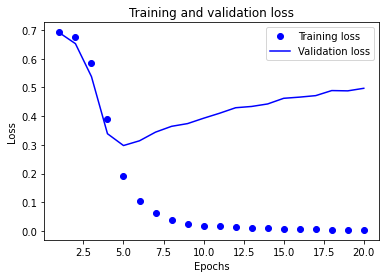

In [71]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

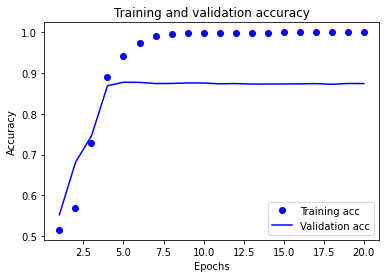

In [72]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### word2vec 시도하기!!!

In [25]:
import os
from gensim import models
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = models.Word2Vec.load(word2vec_path)

In [23]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_path)
vector = word_vectors['사람']
vector

In [ ]:
import np as numpy

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

### 학습 진행 시키기~~~~~

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

# 프로젝트를 제출하며...
여기까지가 끝인가보오... 밤도새고 물어도 보고 했지만,,, 내가 가진 오류는 다른사람들에게는 없어서...
혼자라도 해보려 했지만 결국 해결하지 못했습니다..
시간상 이번 프로젝트는 제출하고, 차차 펀더멘탈을 통해 배워가도록 하겠습니다... ㅠㅠ
너무 지쳤습니다..